# Assignment 2 Tunneling in the Double Potential Well

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Defining Constants
ALPHA = 0.4
N_D = 600
EPSILON = (2 * np.pi) / 128
MASS = H_BAR = 1
X_MIN = np.sqrt(1 / ALPHA)
OMEGA = np.sqrt(8 * ALPHA * X_MIN ** 2)

In [5]:
# Helper Functions

def plot_propagator_matrix(k):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    im1 = ax1.imshow(
        np.real(k),
        origin='lower',
        interpolation='none',
        aspect='auto',
        extent=[0, N_D+1, 0, N_D+1]
    )
    fig.colorbar(im1, ax=ax1, label='Re[K(i, j)]')
    ax1.set_xlabel('j index')
    ax1.set_ylabel('i index')
    ax1.set_title('Elementary Propagator (Real part)')

    im2 = ax2.imshow(
        np.imag(k),
        origin='lower',
        interpolation='none',
        aspect='auto',
        extent=[0, N_D+1, 0, N_D+1]
    )
    fig.colorbar(im2, ax=ax2, label='Im[K(i, j)]')
    ax2.set_xlabel('j index')
    ax2.set_ylabel('i index')
    ax2.set_title('Elementary Propagator (Imag part)')

    plt.tight_layout()
    plt.show()

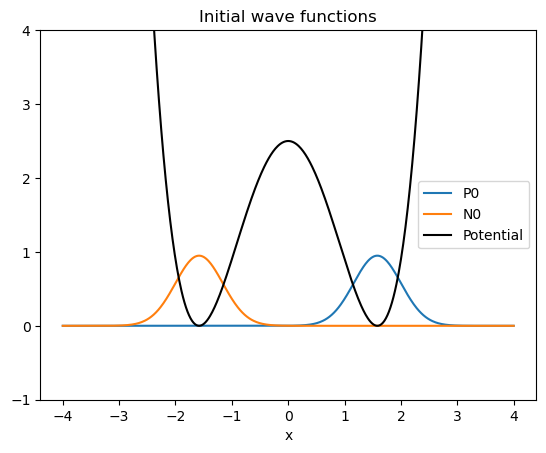

In [ ]:
def potential(x):
    return -2*x**2 + ALPHA*x**4 + 1/ALPHA

def phi_p (x, X_MIN):
    prefactor = (OMEGA / np.pi) ** (1/4)
    exponent = (-OMEGA/2) * (x - X_MIN) ** 2
    return prefactor * np.exp(exponent)

def phi_n (x, X_MIN):
    prefactor = (OMEGA / np.pi) ** (1/4)
    exponent = (-OMEGA/2) * (x + X_MIN) ** 2
    return prefactor * np.exp(exponent)

x_array = np.linspace(-4, 4, N_D + 1)
delta_x = x_array[1] - x_array[0]

potential_array = np.array(
    [potential(x) for x in x_array], 
)

phi_P0 = np.array(
    [phi_p(x, X_MIN) for x in x_array], 
    dtype=np.complex128
)

phi_N0 = np.array(
    [phi_n(x, X_MIN) for x in x_array], 
    dtype=np.complex128
)

plt.plot(x_array, np.abs(phi_P0) ** 2, label='P0')
plt.plot(x_array, np.abs(phi_N0) ** 2, label='N0')
plt.plot(x_array, potential_array, label='Potential', color = 'black')
plt.ylim(-1, 4)
plt.title('Initial wave functions')
plt.xlabel('x')
plt.legend()

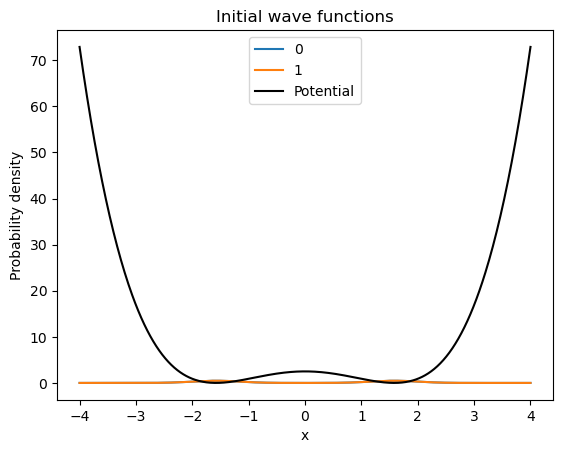

In [7]:
phi_0 = (phi_P0 + phi_N0) / np.sqrt(2)
phi_1 = (phi_P0 - phi_N0) / np.sqrt(2)

plt.plot(x_array, np.abs(phi_0) ** 2, label='0')
plt.plot(x_array, np.abs(phi_1) ** 2, label='1')
plt.plot(x_array, potential_array, label='Potential', color = 'black')

plt.title('Initial wave functions')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()

# Problem A

In [8]:
def normalize_wave_function(psi: np.ndarray) -> np.ndarray:
    return psi / np.sqrt(np.sum(np.abs(psi) ** 2) * delta_x)

def phi_to_probability_density(phi: np.ndarray) -> np.ndarray:
    return np.abs(phi) ** 2

def advance_wave_function(psi: np.ndarray, k: np.ndarray, delta_x: float) -> np.ndarray:
    return np.dot(k, psi) * delta_x

def mean_x_position(psi: np.ndarray, x_array: np.ndarray, delta_x: float ) -> float:
    return np.sum(np.abs(psi) ** 2 * x_array) * delta_x

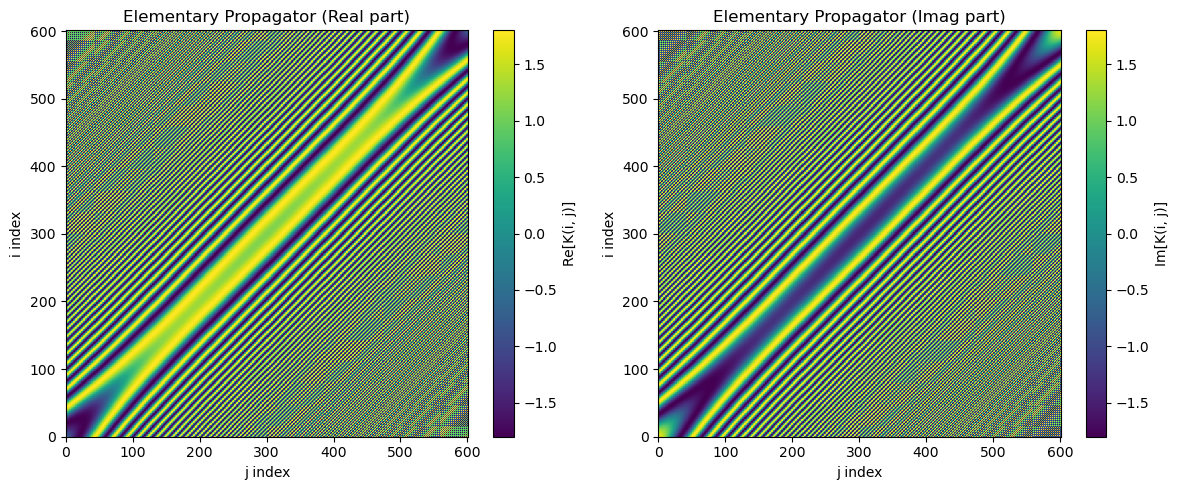

In [9]:
k_eps = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)

def potential(x:float , alpha:float):
    return alpha * x**4 - 2.0 * x**2 + 1.0 / alpha

def elementary_propagator(xi, xj, alpha):
    prefactor = 1.0 / np.sqrt(2.0*np.pi*1j*EPSILON)
    exponent = 1j * (
        0.5*((xj - xi)**2) / EPSILON
        - potential(0.5*(xi + xj), alpha)*EPSILON
    )
    return prefactor * np.exp(exponent)

for i in range(N_D + 1):
    for j in range(N_D + 1):
        k_eps[i, j] = elementary_propagator(x_array[i], x_array[j], ALPHA)

plot_propagator_matrix(k_eps)

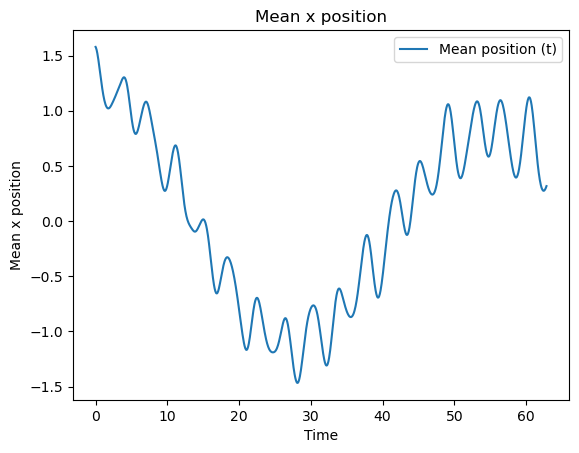

In [10]:
timesteps = 1280
time_array = np.linspace(0, timesteps * EPSILON, timesteps + 1)
phi = phi_P0.copy()

phi_list = []
for i in range(timesteps + 1):
    phi = advance_wave_function(phi, k_eps, delta_x)
    phi = normalize_wave_function(phi)
    phi_list.append(phi)

prob_list = []
for i in range (timesteps + 1):
    prob_density = phi_to_probability_density(phi_list[i])
    prob_list.append(prob_density)

mean_x_list = []
for i in range(timesteps + 1):
    mean_x = mean_x_position(phi_list[i], x_array, delta_x)
    mean_x_list.append(mean_x)

plt.plot(time_array, mean_x_list, label='Mean position (t)')
plt.title('Mean x position')
plt.xlabel('Time')
plt.ylabel('Mean x position')
plt.legend()
plt.show()

In [11]:
# Calculating the Tunneling time
# The particle will have tunneled if its average position moves across the y axis

def get_tunneling_time(mean_x_list, time_array):
    for i in range(timesteps):
        if (mean_x_list[i] < 0) and (mean_x_list[i+1] > 0):
            return time_array[i]


tunneling_time = get_tunneling_time(mean_x_list, time_array)

print(f"Tunneling time: {tunneling_time}")


Tunneling time: 14.726215563702155


# Problem B

In [ ]:
# Computing Hamiltonian Matrix

T_matrix = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)
V_matrix = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)

for i in range(N_D + 1):   
    for j in range(N_D + 1):
        T_matrix[i, j] = -0.5 * H_BAR ** 2 / MASS * (
            (i == j + 1) - 2 * (i == j) + (i == j - 1)
        ) / delta_x ** 2

        V_matrix[i, j] = potential(x_array[i], ALPHA) * (i == j)

H_matrix = T_matrix + V_matrix

phi_0 = normalize_wave_function(phi_0)
phi_1 = normalize_wave_function(phi_1)

E_0 = np.vdot(phi_0, H_matrix @ phi_0) * delta_x
E_1 = np.vdot(phi_1, H_matrix @ phi_1) * delta_x

print(f'Ground state energy: {E_0}')
print(f'First excited state energy: {E_1}')
print(f'Energy difference: {E_1 - E_0}')

Ground state energy: (1.4444201610524074+0j)
First excited state energy: (1.4589646873284239+0j)
Energy difference: (0.014544526276016434+0j)


# Problem C

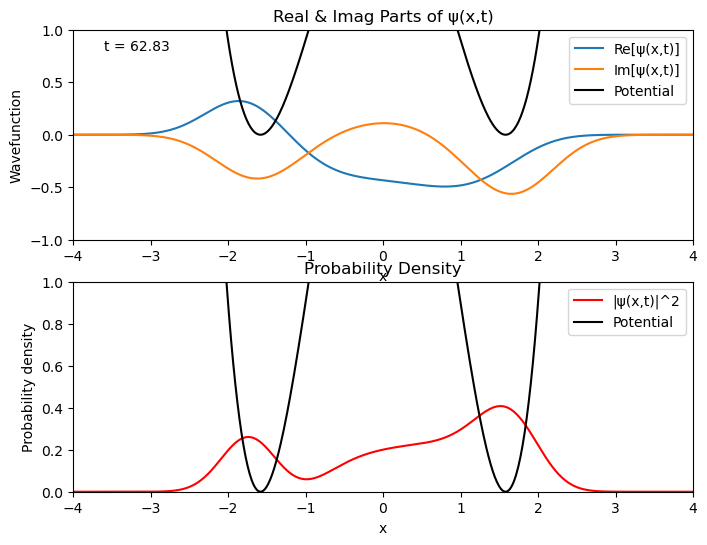

In [13]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

line_real,  = ax1.plot([], [], label='Re[ψ(x,t)]')
line_imag,  = ax1.plot([], [], label='Im[ψ(x,t)]')
ax1.plot(x_array, potential_array, label='Potential', color='black')
ax1.set_xlabel('x')
ax1.set_ylabel('Wavefunction')
ax1.set_title('Real & Imag Parts of ψ(x,t)')
ax1.legend()
ax1.set_xlim(x_array[0], x_array[-1])
ax1.set_ylim(-1.0, 1.0) 

line_prob,  = ax2.plot([], [], color='r', label='|ψ(x,t)|^2')
ax2.plot(x_array, potential_array, label='Potential', color='black')
ax2.set_xlabel('x')
ax2.set_ylabel('Probability density')
ax2.set_title('Probability Density')
ax2.legend()
ax2.set_xlim(x_array[0], x_array[-1])
ax2.set_ylim(0.0, 1.0)


time_text = ax1.text(0.05, 0.90, '', transform=ax1.transAxes)

def init():
    line_real.set_data([], [])
    line_imag.set_data([], [])
    line_prob.set_data([], [])
    time_text.set_text('')
    return line_real, line_imag, line_prob, time_text

def animate(i):
    psi_i = phi_list[i]
    prob_i = prob_list[i]
    
    line_real.set_data(x_array, np.real(psi_i))
    line_imag.set_data(x_array, np.imag(psi_i))
    line_prob.set_data(x_array, prob_i)
    
    t_val = time_array[i]
    time_text.set_text(f't = {t_val:.2f}')
    
    return line_real, line_imag, line_prob, time_text

anim = FuncAnimation(fig, animate, frames=len(phi_list), 
                     init_func=init, interval=30, blit=True)

anim.save('double_well_evolution.gif', writer='pillow', fps=30)

plt.show()


# Problem D

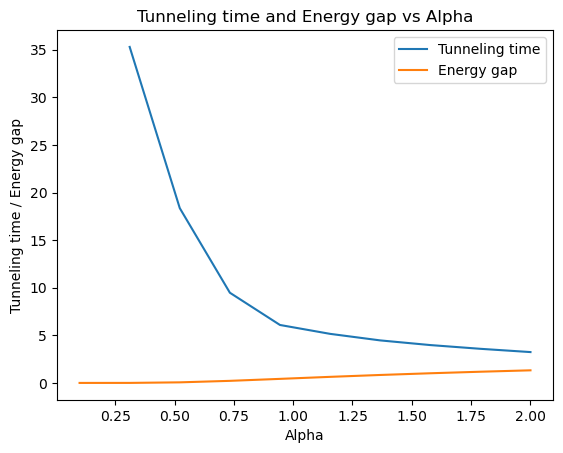

In [14]:
def tunnel_time_and_energy_gap(ALPHA: float):
    X_MIN = np.sqrt(1 / ALPHA)

    k_eps = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)

    for i in range(N_D + 1):
        for j in range(N_D + 1):
            k_eps[i, j] = elementary_propagator(x_array[i], x_array[j], ALPHA)

    phi_P0 = np.array(
        [phi_p(x, X_MIN) for x in x_array], 
        dtype=np.complex128
    )

    phi_N0 = np.array(
        [phi_n(x, X_MIN) for x in x_array], 
        dtype=np.complex128
    )

    phi_0 = 1 / np.sqrt(2) * (phi_P0 + phi_N0)
    phi_1 = 1 / np.sqrt(2) * (phi_P0 - phi_N0)

    timesteps = 1280
    time_array = np.linspace(0, timesteps * EPSILON, timesteps + 1)
    phi = phi_P0.copy()
    
    phi_list = []
    for i in range(timesteps + 1):
        phi = advance_wave_function(phi, k_eps, delta_x)
        phi = normalize_wave_function(phi)
        phi_list.append(phi)

    prob_list = []
    for i in range (timesteps + 1):
        prob_density = phi_to_probability_density(phi_list[i])
        prob_list.append(prob_density)

    mean_x_list = []
    for i in range(timesteps + 1):
        mean_x = mean_x_position(phi_list[i], x_array, delta_x)
        mean_x_list.append(mean_x)
        
    tunneling_time = get_tunneling_time(mean_x_list, time_array)

    phi_0 = normalize_wave_function(phi_0)
    phi_1 = normalize_wave_function(phi_1)

    T_matrix = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)
    V_matrix = np.zeros((N_D + 1, N_D + 1), dtype=np.complex64)

    for i in range(N_D + 1):   
        for j in range(N_D + 1):
            T_matrix[i, j] = -0.5 * H_BAR ** 2 / MASS * (
                (i == j + 1) - 2 * (i == j) + (i == j - 1)
            ) / delta_x ** 2

            V_matrix[i, j] = potential(x_array[i], ALPHA) * (i == j)

    H_matrix = T_matrix + V_matrix

    E_0 = np.vdot(phi_0, H_matrix @ phi_0) * delta_x
    E_1 = np.vdot(phi_1, H_matrix @ phi_1) * delta_x

    delta_E = np.real(E_1 - E_0)

    return tunneling_time, delta_E

alphas = np.linspace(0.1, 2, 10)
tunnel_times = []
energy_gaps = []

for alpha in alphas:
    tunnel_time, delta_E = tunnel_time_and_energy_gap(alpha)
    tunnel_times.append(tunnel_time)
    energy_gaps.append(delta_E)

plt.plot(alphas, tunnel_times)
plt.plot(alphas, energy_gaps)
plt.xlabel('Alpha')
plt.ylabel('Tunneling time / Energy gap')
plt.title('Tunneling time and Energy gap vs Alpha')
plt.legend(['Tunneling time', 'Energy gap'])
plt.show()

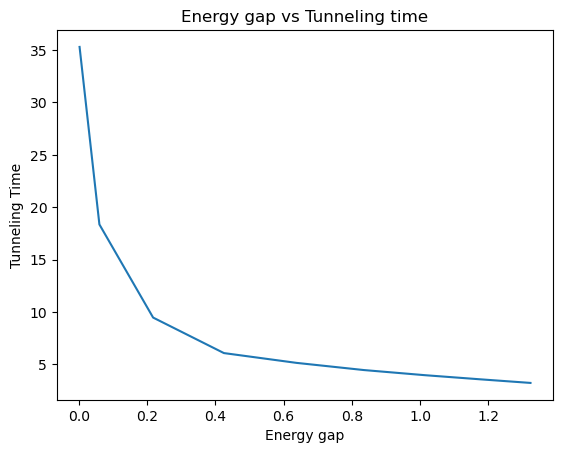

In [15]:
plt.plot(energy_gaps,tunnel_times)
plt.xlabel('Energy gap')
plt.ylabel('Tunneling Time')
plt.title('Energy gap vs Tunneling time')
plt.show()